# Urdu Poetry Generation - Deep Learning Project (Part 2)

This notebook implements the comparative analysis of Sequence-to-Sequence models (RNN, LSTM, Transformer) and optimization algorithms (Adam, RMSprop, SGD) for Urdu poetry generation.

In [1]:
# Install Dependencies
!pip install torch transformers datasets scikit-learn matplotlib seaborn pandas tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 32.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 50.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 14.2 MB/s eta 0:00:0000:0100:01
  Attempting uni

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math
import os
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

# Set device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

Using device: cuda


## 1. Data Loader and Preprocessing

In [3]:
class UrduPoetryTokenizer:
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.vocab_size = 0

    def fit_on_texts(self, texts):
        all_words = []
        for text in texts:
            words = self._clean_and_tokenize(text)
            all_words.extend(words)

        word_counts = Counter(all_words)
        sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

        self.word2idx = {"<PAD>": 0, "<UNK>": 1, "<SOS>": 2, "<EOS>": 3}
        self.idx2word = {0: "<PAD>", 1: "<UNK>", 2: "<SOS>", 3: "<EOS>"}

        idx = 4
        for word, _ in sorted_words:
            if word not in self.word2idx:
                self.word2idx[word] = idx
                self.idx2word[idx] = word
                idx += 1

        self.vocab_size = len(self.word2idx)
        print(f"Vocabulary size: {self.vocab_size}")

    def _clean_and_tokenize(self, text):
        text = str(text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text.split(' ')

    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            words = self._clean_and_tokenize(text)
            seq = [self.word2idx.get(w, self.word2idx["<UNK>"]) for w in words]
            sequences.append(seq)
        return sequences

    def sequences_to_texts(self, sequences):
        texts = []
        for seq in sequences:
            words = [self.idx2word.get(idx, "<UNK>") for idx in seq]
            words = [w for w in words if w not in ["<PAD>", "<SOS>", "<EOS>"]]
            texts.append(" ".join(words))
        return texts

def load_and_process_data(max_seq_len=20, batch_size=128):
    print("Loading dataset...")
    try:
        dataset = load_dataset("ReySajju742/Urdu-Poetry-Dataset")
        data_split = dataset['train'] if 'train' in dataset else dataset['test']

        all_lines = []
        for item in data_split:
            content = item.get('content', '') or item.get('Poem', '') or list(item.values())[0]
            if content:
                lines = content.split('\n')
                all_lines.extend([l for l in lines if l.strip()])

        print(f"Total lines extracted: {len(all_lines)}")

        tokenizer = UrduPoetryTokenizer()
        tokenizer.fit_on_texts(all_lines)

        sequences = tokenizer.texts_to_sequences(all_lines)

        input_sequences = []
        for seq in sequences:
            for i in range(1, len(seq)):
                n_gram_seq = seq[:i+1]
                if len(n_gram_seq) <= max_seq_len + 1:
                    input_sequences.append(n_gram_seq)
                else:
                    input_sequences.append(n_gram_seq[-(max_seq_len+1):])

        print(f"Total sequences created: {len(input_sequences)}")

        padded_sequences = []
        for seq in input_sequences:
            pad_len = (max_seq_len + 1) - len(seq)
            padded_seq = [0] * pad_len + seq
            padded_sequences.append(padded_seq)

        padded_sequences = np.array(padded_sequences)

        X = padded_sequences[:, :-1]
        y = padded_sequences[:, -1]

        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

        train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.long), torch.tensor(y_train, dtype=torch.long))
        val_dataset = torch.utils.data.TensorDataset(torch.tensor(X_val, dtype=torch.long), torch.tensor(y_val, dtype=torch.long))
        test_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test, dtype=torch.long), torch.tensor(y_test, dtype=torch.long))

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        test_loader = DataLoader(test_dataset, batch_size=batch_size)

        return train_loader, val_loader, test_loader, tokenizer

    except Exception as e:
        print(f"Error in data loading: {e}")
        return None, None, None, None

## 2. Model Architectures

In [4]:
class SimpleRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers=2, dropout=0.2):
        super(SimpleRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        embeds = self.embedding(x)
        output, hidden = self.rnn(embeds, hidden)
        prediction = self.fc(output)
        return prediction, hidden

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        embeds = self.embedding(x)
        output, hidden = self.lstm(embeds, hidden)
        prediction = self.fc(output)
        return prediction, hidden

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return x

class TransformerModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, hidden_dim, num_layers=2, dropout=0.2, max_len=100):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoder = PositionalEncoding(embed_dim, max_len)

        encoder_layers = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=hidden_dim, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

        self.fc = nn.Linear(embed_dim, vocab_size)
        self.embed_dim = embed_dim

    def forward(self, x, mask=None):
        embeds = self.embedding(x) * math.sqrt(self.embed_dim)
        embeds = self.pos_encoder(embeds)

        if mask is None:
            seq_len = x.size(1)
            mask = torch.triu(torch.ones(seq_len, seq_len) * float('-inf'), diagonal=1)
            mask = mask.to(x.device)

        output = self.transformer_encoder(embeds, mask=mask, is_causal=True)
        prediction = self.fc(output)
        return prediction, None

## 3. Training and Evaluation Functions

In [5]:
def get_optimizer(model, optimizer_name, learning_rate):
    if optimizer_name.lower() == 'adam':
        return optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name.lower() == 'rmsprop':
        return optim.RMSprop(model.parameters(), lr=learning_rate)
    elif optimizer_name.lower() == 'sgd':
        return optim.SGD(model.parameters(), lr=learning_rate)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

def train_epoch(model, dataloader, criterion, optimizer, device, clip=1.0):
    model.train()
    total_loss = 0

    for batch in dataloader:
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        if isinstance(model, (nn.RNN, nn.LSTM, nn.GRU)):
            outputs, _ = model(inputs)
            output = outputs[:, -1, :]
        else:
            outputs, _ = model(inputs)
            output = outputs[:, -1, :]

        loss = criterion(output, targets)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in dataloader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            if isinstance(model, (nn.RNN, nn.LSTM, nn.GRU)):
                outputs, _ = model(inputs)
                output = outputs[:, -1, :]
            else:
                outputs, _ = model(inputs)
                output = outputs[:, -1, :]

            loss = criterion(output, targets)
            total_loss += loss.item()

            _, predicted = torch.max(output, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    return total_loss / len(dataloader), correct / total

def train_model(model, train_loader, val_loader, optimizer_name, learning_rate, epochs, device, patience=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = get_optimizer(model, optimizer_name, learning_rate)

    best_val_loss = float('inf')
    patience_counter = 0

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_ppl': [],
        'val_ppl': [],
        'val_acc': []
    }

    start_time = time.time()

    for epoch in range(epochs):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        train_ppl = math.exp(train_loss)
        val_ppl = math.exp(val_loss)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_ppl'].append(train_ppl)
        history['val_ppl'].append(val_ppl)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val PPL: {val_ppl:.4f} | Val Acc: {val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break

    total_time = time.time() - start_time
    return history, total_time

def generate_text(model, tokenizer, seed_text, max_length=20, temperature=1.0, device='cpu'):
    model.eval()
    words = tokenizer._clean_and_tokenize(seed_text)
    current_seq = [tokenizer.word2idx.get(w, tokenizer.word2idx["<UNK>"]) for w in words]

    generated_words = []

    with torch.no_grad():
        for _ in range(max_length):
            inp = torch.tensor([current_seq], dtype=torch.long).to(device)
            if inp.size(1) > 100:
                 inp = inp[:, -100:]

            if isinstance(model, (torch.nn.RNN, torch.nn.LSTM, torch.nn.GRU)):
                outputs, _ = model(inp)
                output = outputs[:, -1, :]
            else:
                outputs, _ = model(inp)
                output = outputs[:, -1, :]

            output = output / temperature
            probs = F.softmax(output, dim=-1)
            next_token_idx = torch.multinomial(probs, 1).item()

            current_seq.append(next_token_idx)
            word = tokenizer.idx2word.get(next_token_idx, "<UNK>")
            generated_words.append(word)

            if word == "<EOS>":
                break

    return seed_text + " " + " ".join(generated_words)

## 4. Run Experiments

Loading dataset...


README.md: 0.00B [00:00, ?B/s]

output_ur.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/1323 [00:00<?, ? examples/s]

Total lines extracted: 21077
Vocabulary size: 10520
Total sequences created: 152146

=== Running Experiment: RNN + Adam ===
Epoch 1/20 | Train Loss: 7.0811 | Val Loss: 6.8319 | Val PPL: 926.9600 | Val Acc: 0.0553
Epoch 2/20 | Train Loss: 6.6046 | Val Loss: 6.6852 | Val PPL: 800.4888 | Val Acc: 0.0794
Epoch 3/20 | Train Loss: 6.1897 | Val Loss: 6.6354 | Val PPL: 761.6065 | Val Acc: 0.0879
Epoch 4/20 | Train Loss: 5.7255 | Val Loss: 6.7133 | Val PPL: 823.3100 | Val Acc: 0.0942
Epoch 5/20 | Train Loss: 5.2744 | Val Loss: 6.8002 | Val PPL: 898.0542 | Val Acc: 0.0958
Epoch 6/20 | Train Loss: 4.8655 | Val Loss: 6.9210 | Val PPL: 1013.3263 | Val Acc: 0.0958
Epoch 7/20 | Train Loss: 4.5224 | Val Loss: 7.0512 | Val PPL: 1154.2058 | Val Acc: 0.0950
Epoch 8/20 | Train Loss: 4.2358 | Val Loss: 7.1731 | Val PPL: 1303.9376 | Val Acc: 0.0951
Early stopping triggered after 8 epochs.
Test Results: Loss=7.1622, PPL=1289.7365, Acc=0.0967

=== Detailed Text Generation Analysis ===

--- Temperature: 0.7 --

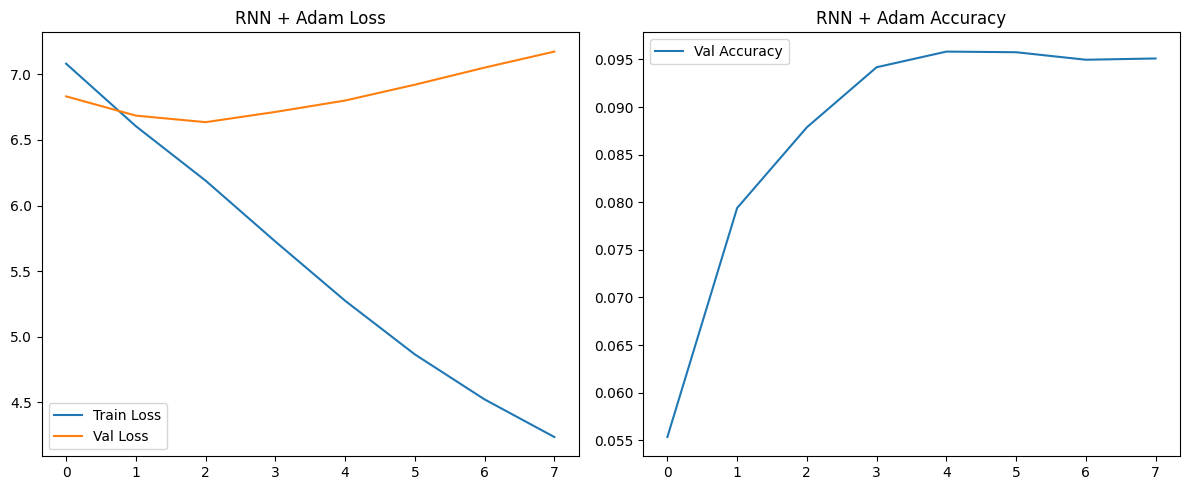


=== Running Experiment: RNN + RMSprop ===
Epoch 1/20 | Train Loss: 7.2824 | Val Loss: 7.0434 | Val PPL: 1145.2656 | Val Acc: 0.0451
Epoch 2/20 | Train Loss: 6.8456 | Val Loss: 6.7862 | Val PPL: 885.5216 | Val Acc: 0.0638
Epoch 3/20 | Train Loss: 6.5531 | Val Loss: 6.6904 | Val PPL: 804.6696 | Val Acc: 0.0747
Epoch 4/20 | Train Loss: 6.2716 | Val Loss: 6.6586 | Val PPL: 779.4765 | Val Acc: 0.0829
Epoch 5/20 | Train Loss: 5.9840 | Val Loss: 6.6174 | Val PPL: 748.0252 | Val Acc: 0.0924
Epoch 6/20 | Train Loss: 5.7012 | Val Loss: 6.6108 | Val PPL: 743.1036 | Val Acc: 0.0966
Epoch 7/20 | Train Loss: 5.4230 | Val Loss: 6.6310 | Val PPL: 758.2589 | Val Acc: 0.0975
Epoch 8/20 | Train Loss: 5.1634 | Val Loss: 6.6535 | Val PPL: 775.5045 | Val Acc: 0.1020
Epoch 9/20 | Train Loss: 4.9189 | Val Loss: 6.6892 | Val PPL: 803.6457 | Val Acc: 0.0982
Epoch 10/20 | Train Loss: 4.6822 | Val Loss: 6.7351 | Val PPL: 841.4629 | Val Acc: 0.1002
Epoch 11/20 | Train Loss: 4.4620 | Val Loss: 6.7867 | Val PPL: 88

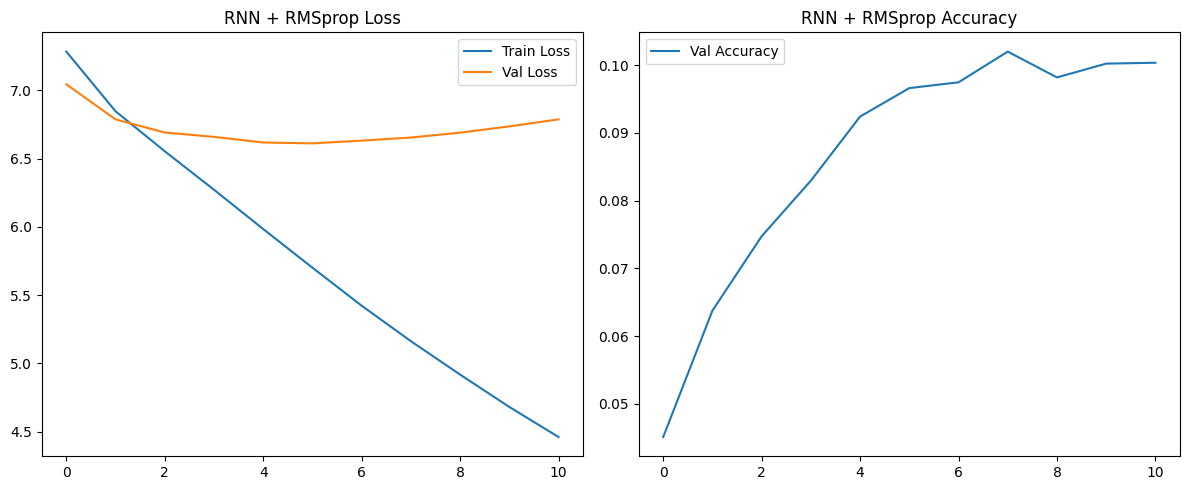


=== Running Experiment: RNN + SGD ===
Epoch 1/20 | Train Loss: 7.9312 | Val Loss: 7.1935 | Val PPL: 1330.7935 | Val Acc: 0.0452
Epoch 2/20 | Train Loss: 7.0780 | Val Loss: 6.9688 | Val PPL: 1062.9763 | Val Acc: 0.0452
Epoch 3/20 | Train Loss: 6.9351 | Val Loss: 6.8892 | Val PPL: 981.5771 | Val Acc: 0.0467
Epoch 4/20 | Train Loss: 6.8712 | Val Loss: 6.8452 | Val PPL: 939.3417 | Val Acc: 0.0452
Epoch 5/20 | Train Loss: 6.8328 | Val Loss: 6.8174 | Val PPL: 913.6248 | Val Acc: 0.0452
Epoch 6/20 | Train Loss: 6.8059 | Val Loss: 6.7960 | Val PPL: 894.2776 | Val Acc: 0.0460
Epoch 7/20 | Train Loss: 6.7843 | Val Loss: 6.7778 | Val PPL: 878.1170 | Val Acc: 0.0477
Epoch 8/20 | Train Loss: 6.7651 | Val Loss: 6.7625 | Val PPL: 864.7850 | Val Acc: 0.0486
Epoch 9/20 | Train Loss: 6.7471 | Val Loss: 6.7470 | Val PPL: 851.5265 | Val Acc: 0.0515
Epoch 10/20 | Train Loss: 6.7286 | Val Loss: 6.7301 | Val PPL: 837.2224 | Val Acc: 0.0529
Epoch 11/20 | Train Loss: 6.7111 | Val Loss: 6.7153 | Val PPL: 824.9

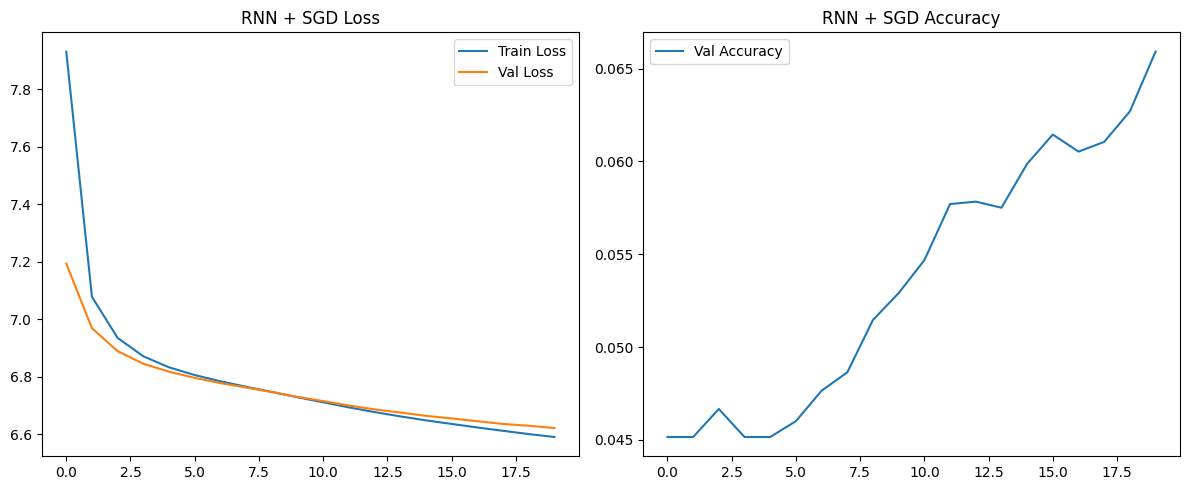


=== Running Experiment: LSTM + Adam ===
Epoch 1/20 | Train Loss: 6.7774 | Val Loss: 6.4919 | Val PPL: 659.7663 | Val Acc: 0.0735
Epoch 2/20 | Train Loss: 6.2517 | Val Loss: 6.2929 | Val PPL: 540.7392 | Val Acc: 0.0949
Epoch 3/20 | Train Loss: 5.8623 | Val Loss: 6.2146 | Val PPL: 499.9926 | Val Acc: 0.1097
Epoch 4/20 | Train Loss: 5.4320 | Val Loss: 6.2349 | Val PPL: 510.2425 | Val Acc: 0.1141
Epoch 5/20 | Train Loss: 4.9428 | Val Loss: 6.3535 | Val PPL: 574.4953 | Val Acc: 0.1161
Epoch 6/20 | Train Loss: 4.3886 | Val Loss: 6.5485 | Val PPL: 698.2244 | Val Acc: 0.1132
Epoch 7/20 | Train Loss: 3.8683 | Val Loss: 6.7603 | Val PPL: 862.9289 | Val Acc: 0.1132
Epoch 8/20 | Train Loss: 3.3981 | Val Loss: 6.9856 | Val PPL: 1080.9437 | Val Acc: 0.1106
Early stopping triggered after 8 epochs.
Test Results: Loss=6.9851, PPL=1080.3765, Acc=0.1158

=== Detailed Text Generation Analysis ===

--- Temperature: 0.7 ---
Seed: محبت | Temp: 0.7 -> محبت کو بھر جانا چاہئے تھا وہ جانتا کہ مری جاں پر نئے بھڑ

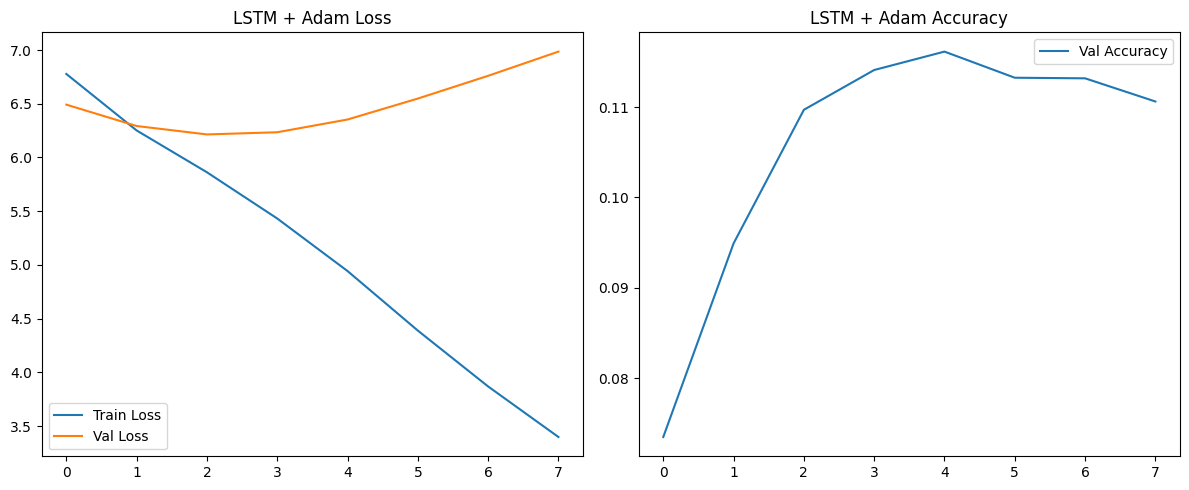


=== Running Experiment: LSTM + RMSprop ===
Epoch 1/20 | Train Loss: 6.6455 | Val Loss: 6.3860 | Val PPL: 593.5013 | Val Acc: 0.0879
Epoch 2/20 | Train Loss: 6.0979 | Val Loss: 6.2729 | Val PPL: 530.0012 | Val Acc: 0.1040
Epoch 3/20 | Train Loss: 5.6603 | Val Loss: 6.2538 | Val PPL: 519.9681 | Val Acc: 0.1134
Epoch 4/20 | Train Loss: 5.1796 | Val Loss: 6.3343 | Val PPL: 563.5989 | Val Acc: 0.1138
Epoch 5/20 | Train Loss: 4.6769 | Val Loss: 6.5059 | Val PPL: 669.0609 | Val Acc: 0.1153
Epoch 6/20 | Train Loss: 4.1756 | Val Loss: 6.7336 | Val PPL: 840.1295 | Val Acc: 0.1106
Epoch 7/20 | Train Loss: 3.6946 | Val Loss: 6.9965 | Val PPL: 1092.8479 | Val Acc: 0.1073
Epoch 8/20 | Train Loss: 3.2567 | Val Loss: 7.2302 | Val PPL: 1380.4422 | Val Acc: 0.1038
Early stopping triggered after 8 epochs.
Test Results: Loss=7.2031, PPL=1343.5538, Acc=0.1101

=== Detailed Text Generation Analysis ===

--- Temperature: 0.7 ---
Seed: محبت | Temp: 0.7 -> محبت میں مت دیکھا کرو ہوئی مجھ سے میں نے وہ جانا دیکھ

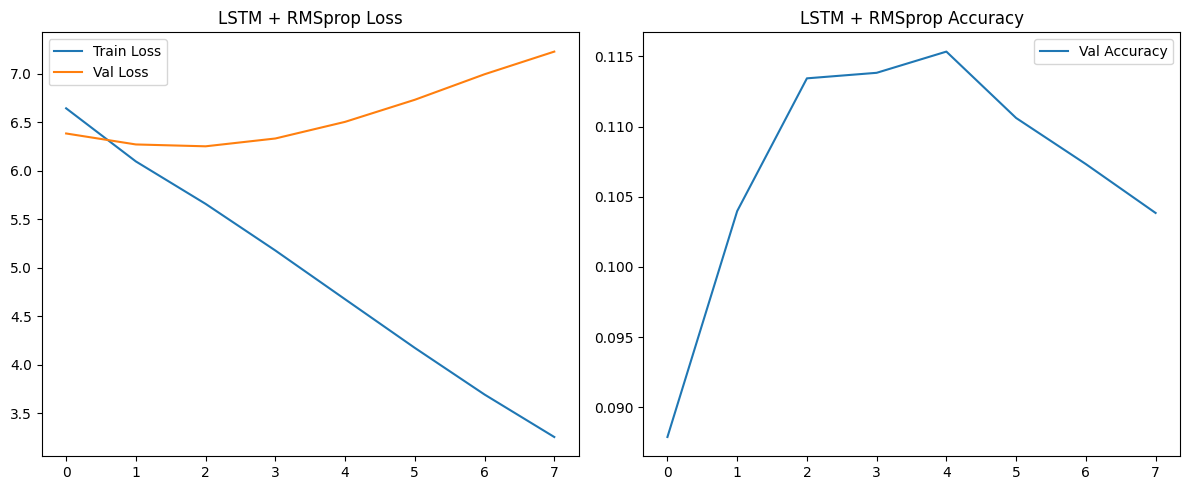


=== Running Experiment: LSTM + SGD ===
Epoch 1/20 | Train Loss: 9.1651 | Val Loss: 8.8756 | Val PPL: 7155.3830 | Val Acc: 0.0452
Epoch 2/20 | Train Loss: 7.7627 | Val Loss: 7.2268 | Val PPL: 1375.7834 | Val Acc: 0.0452
Epoch 3/20 | Train Loss: 7.1134 | Val Loss: 6.9967 | Val PPL: 1093.0584 | Val Acc: 0.0452
Epoch 4/20 | Train Loss: 6.9618 | Val Loss: 6.9079 | Val PPL: 1000.1640 | Val Acc: 0.0452
Epoch 5/20 | Train Loss: 6.8934 | Val Loss: 6.8617 | Val PPL: 954.9465 | Val Acc: 0.0452
Epoch 6/20 | Train Loss: 6.8532 | Val Loss: 6.8346 | Val PPL: 929.4299 | Val Acc: 0.0452
Epoch 7/20 | Train Loss: 6.8270 | Val Loss: 6.8141 | Val PPL: 910.6199 | Val Acc: 0.0452
Epoch 8/20 | Train Loss: 6.8081 | Val Loss: 6.7997 | Val PPL: 897.5407 | Val Acc: 0.0452
Epoch 9/20 | Train Loss: 6.7936 | Val Loss: 6.7899 | Val PPL: 888.8675 | Val Acc: 0.0452
Epoch 10/20 | Train Loss: 6.7824 | Val Loss: 6.7817 | Val PPL: 881.5484 | Val Acc: 0.0452
Epoch 11/20 | Train Loss: 6.7733 | Val Loss: 6.7749 | Val PPL: 87

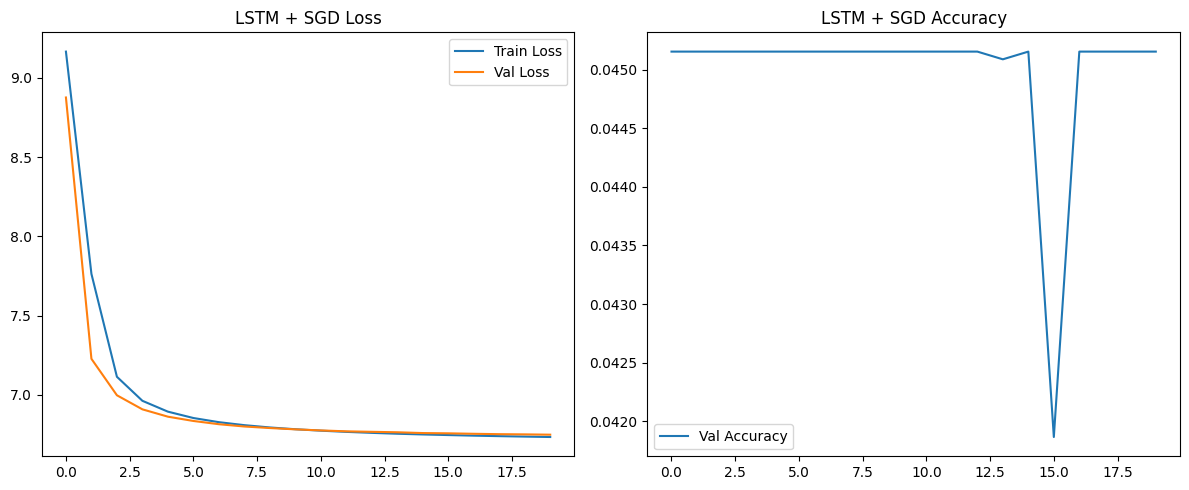


=== Running Experiment: Transformer + Adam ===
Epoch 1/20 | Train Loss: 7.0023 | Val Loss: 6.6966 | Val PPL: 809.6439 | Val Acc: 0.0597
Epoch 2/20 | Train Loss: 6.5455 | Val Loss: 6.5667 | Val PPL: 711.0470 | Val Acc: 0.0727
Epoch 3/20 | Train Loss: 6.3453 | Val Loss: 6.4852 | Val PPL: 655.3648 | Val Acc: 0.0781
Epoch 4/20 | Train Loss: 6.1726 | Val Loss: 6.4311 | Val PPL: 620.8774 | Val Acc: 0.0854
Epoch 5/20 | Train Loss: 6.0137 | Val Loss: 6.3859 | Val PPL: 593.4302 | Val Acc: 0.0893
Epoch 6/20 | Train Loss: 5.8676 | Val Loss: 6.3539 | Val PPL: 574.7147 | Val Acc: 0.0935
Epoch 7/20 | Train Loss: 5.7328 | Val Loss: 6.3447 | Val PPL: 569.4657 | Val Acc: 0.0962
Epoch 8/20 | Train Loss: 5.6045 | Val Loss: 6.3377 | Val PPL: 565.4897 | Val Acc: 0.0974
Epoch 9/20 | Train Loss: 5.4845 | Val Loss: 6.3502 | Val PPL: 572.5876 | Val Acc: 0.0982
Epoch 10/20 | Train Loss: 5.3701 | Val Loss: 6.3580 | Val PPL: 577.0843 | Val Acc: 0.1021
Epoch 11/20 | Train Loss: 5.2599 | Val Loss: 6.3802 | Val PPL

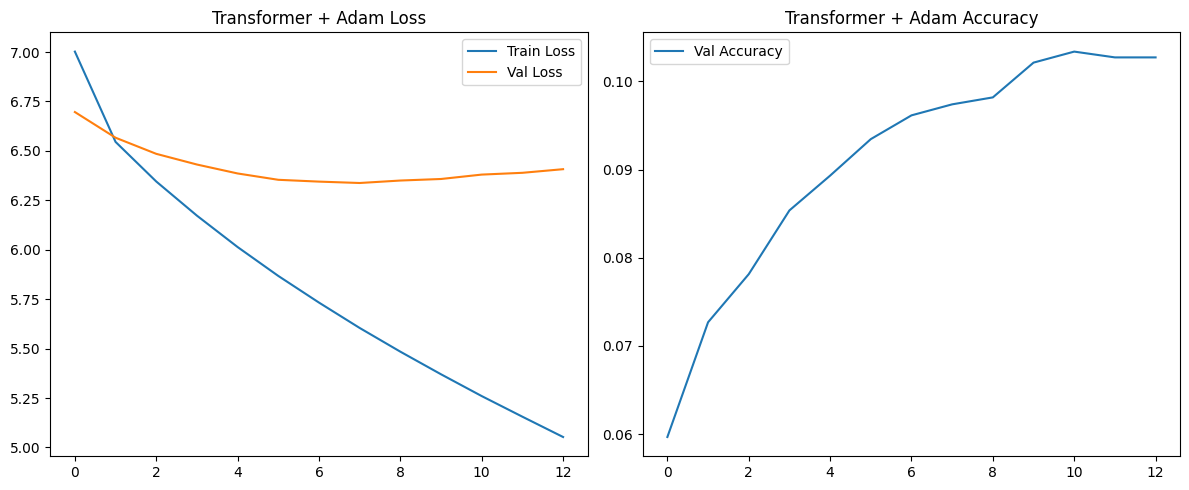


=== Running Experiment: Transformer + RMSprop ===
Epoch 1/20 | Train Loss: 6.9678 | Val Loss: 6.9006 | Val PPL: 992.8408 | Val Acc: 0.0454
Epoch 2/20 | Train Loss: 6.7856 | Val Loss: 6.8978 | Val PPL: 990.0544 | Val Acc: 0.0479
Epoch 3/20 | Train Loss: 6.7379 | Val Loss: 6.9430 | Val PPL: 1035.9220 | Val Acc: 0.0473
Epoch 4/20 | Train Loss: 6.6998 | Val Loss: 6.9523 | Val PPL: 1045.5918 | Val Acc: 0.0505
Epoch 5/20 | Train Loss: 6.6605 | Val Loss: 6.9307 | Val PPL: 1023.2547 | Val Acc: 0.0508
Epoch 6/20 | Train Loss: 6.6122 | Val Loss: 6.8519 | Val PPL: 945.6982 | Val Acc: 0.0540
Epoch 7/20 | Train Loss: 6.5754 | Val Loss: 6.7914 | Val PPL: 890.1263 | Val Acc: 0.0580
Epoch 8/20 | Train Loss: 6.5405 | Val Loss: 6.7453 | Val PPL: 850.0307 | Val Acc: 0.0596
Epoch 9/20 | Train Loss: 6.5043 | Val Loss: 6.7445 | Val PPL: 849.4086 | Val Acc: 0.0646
Epoch 10/20 | Train Loss: 6.4764 | Val Loss: 6.7027 | Val PPL: 814.6381 | Val Acc: 0.0677
Epoch 11/20 | Train Loss: 6.4503 | Val Loss: 6.6661 | V

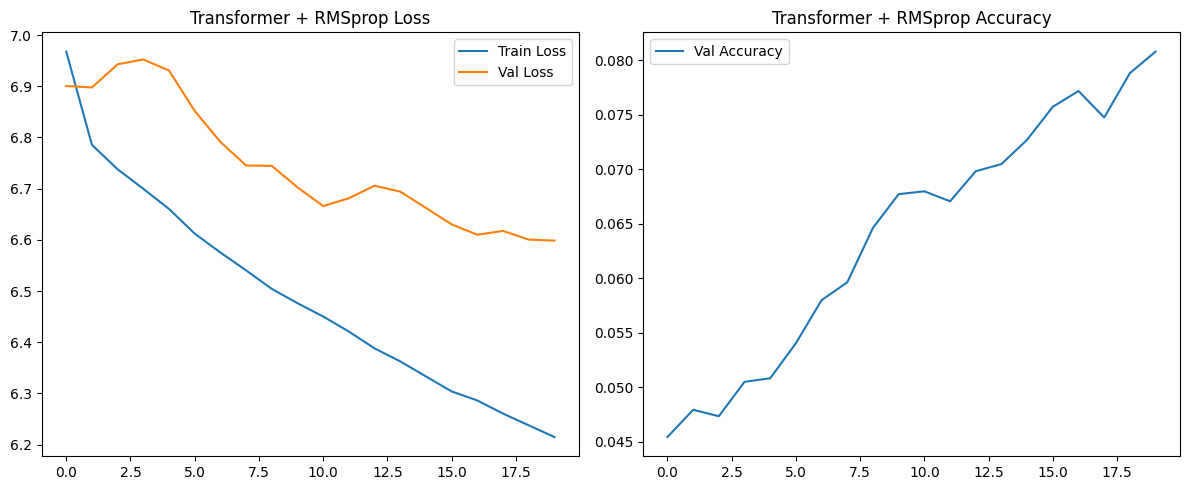


=== Running Experiment: Transformer + SGD ===
Epoch 1/20 | Train Loss: 8.4186 | Val Loss: 7.5849 | Val PPL: 1968.1563 | Val Acc: 0.0457
Epoch 2/20 | Train Loss: 7.4090 | Val Loss: 7.1923 | Val PPL: 1329.2037 | Val Acc: 0.0458
Epoch 3/20 | Train Loss: 7.1424 | Val Loss: 7.0280 | Val PPL: 1127.7920 | Val Acc: 0.0468
Epoch 4/20 | Train Loss: 7.0166 | Val Loss: 6.9434 | Val PPL: 1036.2707 | Val Acc: 0.0457
Epoch 5/20 | Train Loss: 6.9422 | Val Loss: 6.8910 | Val PPL: 983.4018 | Val Acc: 0.0479
Epoch 6/20 | Train Loss: 6.8919 | Val Loss: 6.8521 | Val PPL: 945.8940 | Val Acc: 0.0491
Epoch 7/20 | Train Loss: 6.8528 | Val Loss: 6.8212 | Val PPL: 917.0493 | Val Acc: 0.0518
Epoch 8/20 | Train Loss: 6.8203 | Val Loss: 6.7941 | Val PPL: 892.6010 | Val Acc: 0.0532
Epoch 9/20 | Train Loss: 6.7919 | Val Loss: 6.7736 | Val PPL: 874.4245 | Val Acc: 0.0555
Epoch 10/20 | Train Loss: 6.7671 | Val Loss: 6.7521 | Val PPL: 855.8457 | Val Acc: 0.0584
Epoch 11/20 | Train Loss: 6.7441 | Val Loss: 6.7356 | Val 

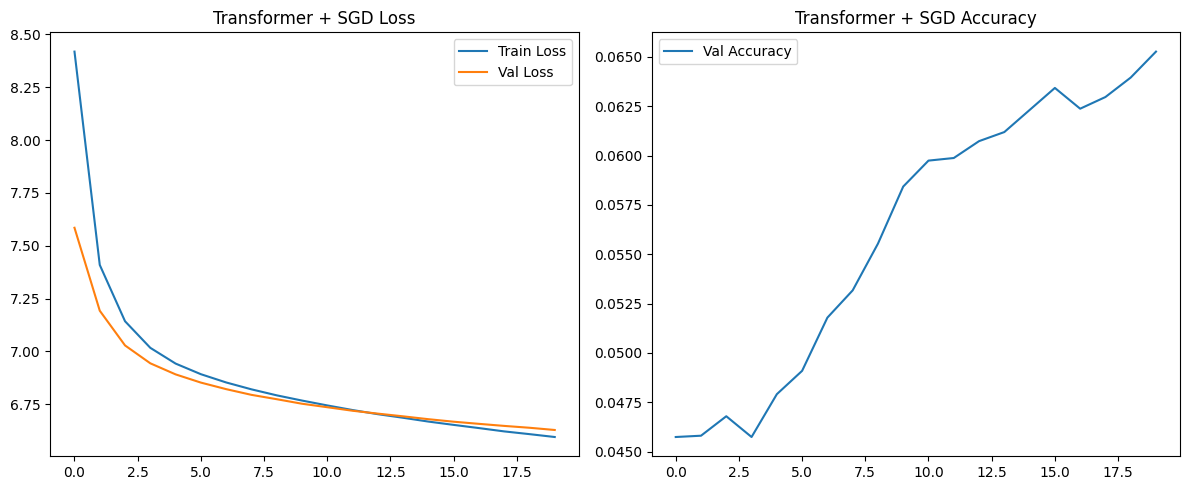

In [6]:
# Configuration
BATCH_SIZE = 128
MAX_SEQ_LEN = 20
EMBED_DIM = 256
HIDDEN_DIM = 512
NUM_LAYERS = 2
EPOCHS = 20 # Full epochs for Colab
PATIENCE = 5

# Load Data
train_loader, val_loader, test_loader, tokenizer = load_and_process_data(max_seq_len=MAX_SEQ_LEN, batch_size=BATCH_SIZE)

vocab_size = tokenizer.vocab_size

models_to_test = ['RNN', 'LSTM', 'Transformer']
optimizers_to_test = ['Adam', 'RMSprop', 'SGD']

results = []
if os.path.exists('generated_samples.txt'):
    os.remove('generated_samples.txt')

if not os.path.exists('results'):
    os.makedirs('results')

for model_name in models_to_test:
    for opt_name in optimizers_to_test:
        print(f"\n=== Running Experiment: {model_name} + {opt_name} ===")

        if model_name == 'RNN':
            model = SimpleRNN(vocab_size, EMBED_DIM, HIDDEN_DIM, NUM_LAYERS).to(DEVICE)
            lr = 0.001 if opt_name != 'SGD' else 0.01
        elif model_name == 'LSTM':
            model = LSTMModel(vocab_size, EMBED_DIM, HIDDEN_DIM, NUM_LAYERS).to(DEVICE)
            lr = 0.001 if opt_name != 'SGD' else 0.01
        elif model_name == 'Transformer':
            model = TransformerModel(vocab_size, EMBED_DIM, num_heads=4, hidden_dim=HIDDEN_DIM, num_layers=NUM_LAYERS, max_len=MAX_SEQ_LEN+1).to(DEVICE)
            lr = 0.0001 if opt_name == 'Adam' else 0.001
            if opt_name == 'SGD': lr = 0.01

        history, train_time = train_model(model, train_loader, val_loader, opt_name, lr, EPOCHS, DEVICE, PATIENCE)

        # Evaluate
        criterion = nn.CrossEntropyLoss()
        test_loss, test_acc = evaluate(model, test_loader, criterion, DEVICE)
        test_ppl = math.exp(test_loss)
        print(f"Test Results: Loss={test_loss:.4f}, PPL={test_ppl:.4f}, Acc={test_acc:.4f}")

        # 4.1 Generation Test Cases (Section 4)
        seed_words = ["محبت", "دل", "شام", "یاد", "خوشی"]
        temperatures = [0.7, 1.0, 1.3]

        print("\n=== Detailed Text Generation Analysis ===")
        with open('generated_samples.txt', 'a', encoding='utf-8') as f:
            f.write(f"\n=== {model_name} + {opt_name} ===\n")
            for temp in temperatures:
                print(f"\n--- Temperature: {temp} ---")
                f.write(f"\n--- Temperature: {temp} ---\n")
                for seed in seed_words:
                    gen_text = generate_text(model, tokenizer, seed, max_length=15, temperature=temp, device=DEVICE)
                    print(f"Seed: {seed} | Temp: {temp} -> {gen_text}")
                    f.write(f"Seed: {seed} | Temp: {temp} -> {gen_text}\n")

        results.append({
            'Model': model_name,
            'Optimizer': opt_name,
            'Test Loss': test_loss,
            'Test PPL': test_ppl,
            'Test Acc': test_acc,
            'Train Time': train_time,
            'Epochs': len(history['train_loss'])
        })

        # Plot Loss and Accuracy
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history['train_loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Val Loss')
        plt.title(f'{model_name} + {opt_name} Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history['val_acc'], label='Val Accuracy')
        plt.title(f'{model_name} + {opt_name} Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.savefig(f'training_history_{model_name}_{opt_name}.png')
        plt.show()
        plt.close()

df = pd.DataFrame(results)
df.to_csv('results/experiment_results.csv', index=False)



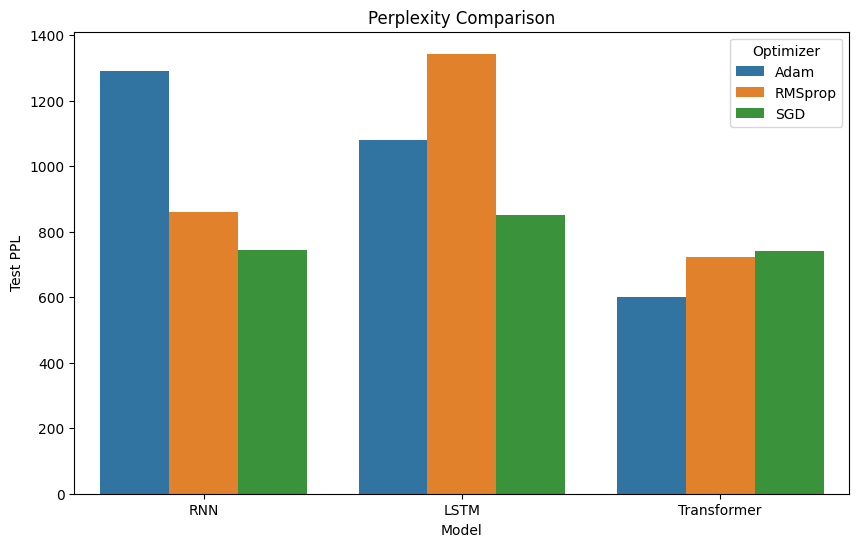

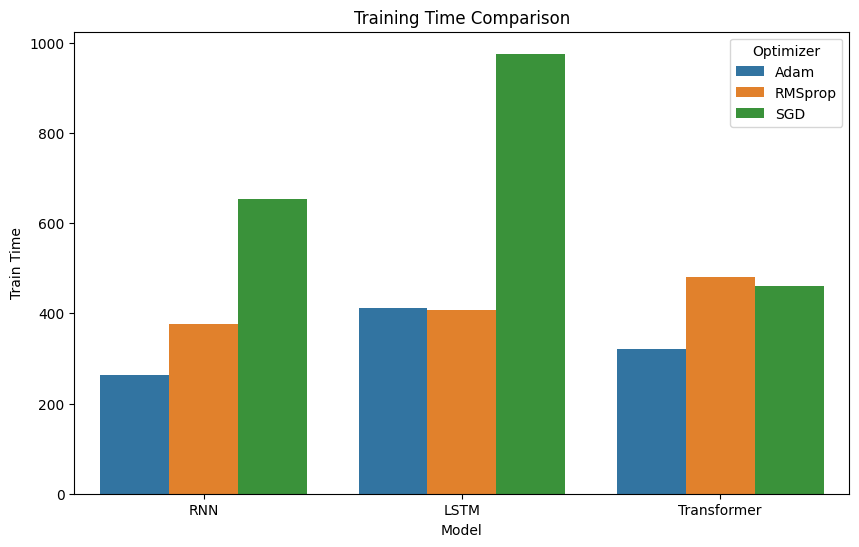

In [7]:
# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Test PPL', hue='Optimizer', data=df)
plt.title('Perplexity Comparison')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Train Time', hue='Optimizer', data=df)
plt.title('Training Time Comparison')
plt.show()

# 4. Text Generation & Evaluation
This section generates text samples for each model-optimizer combination using different temperatures and evaluates them using quantitative metrics.


In [ ]:
import pandas as pd
import numpy as np

def calculate_metrics(text):
    words = text.split()
    if not words: return 0, 0, 0
    vocab_diversity = len(set(words)) / len(words)
    repetition_rate = 1.0 - vocab_diversity
    avg_word_len = np.mean([len(w) for w in words])
    return vocab_diversity, repetition_rate, avg_word_len

seed_words = ["محبت", "دل", "شام", "یاد", "خوشی"]
temperatures = [0.7, 1.0, 1.3]

gen_results = []

print("Starting Detailed Generation Analysis...")
print("Note: Re-training models for generation as they were not persisted in previous cells.")

# Re-run loop for generation
for model_name in ['RNN', 'LSTM', 'Transformer']:
    for opt_name in ['Adam', 'RMSprop', 'SGD']:
        print(f"\nProcessing {model_name} + {opt_name}...")

        # Re-init Model
        if model_name == 'RNN':
            model = SimpleRNN(vocab_size, EMBED_DIM, HIDDEN_DIM, NUM_LAYERS).to(DEVICE)
            lr = 0.001 if opt_name != 'SGD' else 0.01
        elif model_name == 'LSTM':
            model = LSTMModel(vocab_size, EMBED_DIM, HIDDEN_DIM, NUM_LAYERS).to(DEVICE)
            lr = 0.001 if opt_name != 'SGD' else 0.01
        elif model_name == 'Transformer':
            model = TransformerModel(vocab_size, EMBED_DIM, num_heads=4, hidden_dim=HIDDEN_DIM, num_layers=NUM_LAYERS, max_len=MAX_SEQ_LEN+1).to(DEVICE)
            lr = 0.0001 if opt_name == 'Adam' else 0.001
            if opt_name == 'SGD': lr = 0.01

        # Train (Using global EPOCHS/PATIENCE)
        train_model(model, train_loader, val_loader, opt_name, lr, EPOCHS, DEVICE, PATIENCE)

        # Generate & Evaluate
        for seed in seed_words:
            for temp in temperatures:
                text = generate_text(model, tokenizer, seed, max_length=15, temperature=temp, device=DEVICE)
                div, rep, length = calculate_metrics(text)

                gen_results.append({
                    'Model': model_name,
                    'Optimizer': opt_name,
                    'Seed': seed,
                    'Temperature': temp,
                    'Generated Text': text,
                    'Diversity': div,
                    'Repetition': rep,
                    'Avg Length': length
                })

gen_df = pd.DataFrame(gen_results)
print("\nGeneration Analysis Results:")
display(gen_df)
gen_df.to_csv('generation_analysis_results.csv', index=False)



In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=gen_df)